# Diagnosing MAGICC's TCR, ECS and TCRE

In [1]:
# NBVAL_IGNORE_OUTPUT
from datetime import datetime

from pymagicc.core import MAGICC6
from pymagicc.io import MAGICCData
import utils
import pandas as pd

<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting `pyam` logging level to `logging.INFO` and adding stderr handler


In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%config InlineBackend.font.size = 12

In [3]:
magcfg = {    
    'core_climatesensitivity' : 3.257,            # [2.4-3.5] best linefits for 2015-2020 Current Temps
    'core_feedback_qsensitivity': 0,
    'core_verticaldiffusivity' : 2,
    'core_verticaldiffusivity_min' : 0.1,
    'core_verticaldiff_top_dkdt' : 0,
    'core_adjust_sst2ocnatm' : 1.25,
    'core_rlo' : 1.45,
    'core_heatxchange_landocean' : 2.35,
    'core_amplify_ocn2land_heatxchng' : .9,
    'core_heatxchange_northsouth' : 3.45,
    'co2_preindco2conc' : 276.744,
    # f_terr initial bin sizes
    'co2_gpp_initial' : 40,
    'co2_plantpool_initial' : 450,
    'co2_detrituspool_initial' : 85,
    'co2_soilpool_initial' : 1100,
    'co2_respiration_initial' : 12,
    # start of fluxes ∆
    'co2_fraction_gpp_2_plant' : 0.305,
    'co2_fraction_gpp_2_detritus' : 0.3,
    'co2_fraction_plant_2_detritus' : 0.35,
    'co2_fraction_detritus_2_soil' : 0.3,
    'co2_fraction_deforest_plant' : 0.29,
    'co2_fraction_deforest_detritus' : .4,
    'co2_tempfeedback_yrstart' : 1750,
    'co2_tempfeedback_switch' : 1,
    'co2_feedbackfactor_gpp' : 0,
    'co2_feedbackfactor_detritus' : 0,
    'co2_feedbackfactor_soil' : 0.046,
    'co2_feedbackfactor_respiration' : 0,
    'co2_fertilization_yrstart' : 1750,
    'co2_fertilization_method' : 1.03,
    'co2_fertilization_factor' : .63,
    'co2_gifford_conc_for_zeronpp' : 31,
    'co2_norgrwth_frac_defo' : .5,
         }

def renameindex(newname,oldname,mgdata):
    df = mgdata.timeseries().copy()
    #edits()
    #CCC_flat = CCC_flat.rename(index={'CCCx2050':'CCCxflat'})
    newdf = df.rename(index={oldname:newname})
    mgd = MAGICCData(newdf.copy())
    return(mgd)

## Basic usage

The simplest option is to simply call the `utils.diagnose_tcr_ecs_tcre` method in the utility funcions. It caculates ECS, TCR and TCRE, then it returns those values and the `MAGICCdata['timeseries']`.

Usage: utils.diagnose_tcr_ecs_tcre(pos|neg, **kwargs)

It also prints the idealized emissions or concentration that was used for the calculations.

If we wish, we can alter the MAGICC instance's parameters before calling the `diagnose_tcr_ecs` method. 

In [4]:
ndf = pd.DataFrame()
with MAGICC6() as magicc:
    tests = { 'low_ecs': magcfg['core_climatesensitivity']-.5, 
             'default_ecs': magcfg['core_climatesensitivity'], 
             'high_ecs': magcfg['core_climatesensitivity']+.5 }
    rcollection = {}
    for name, cs in tests.items():
        for test in 'neg', 'pos':
            print('Testing {} of {}K:'.format(name, cs))
            results_name = name + '_' + test
            results_data = utils.diagnose_tcr_ecs_tcre( test, 
                                    CORE_CLIMATESENSITIVITY=cs,
                                    CORE_DELQ2XCO2=3.71,
                                    **magcfg )
            print(
            'Default TCR is {tcr:.4f}, ECS is {ecs:.4f} and TCRE is {tcre[0]:.6f} {tcre[1]}\n'.format(
                **results_data)
            )
            rcollection[results_name] = results_data
            scens = results_data['timeseries']['scenario'].unique()
            for scen in scens:
                df = results_data['timeseries'].filter(scenario=scen).timeseries()
                df = df.rename(index={scen:scen+'_'+results_name})
                ndf = ndf.append(df)
            rcollection[results_name]['timeseries'] = MAGICCData(ndf.copy())

Testing low_ecs of 2.757K:
Calculating ECS from abrupt-0p5xCO2.
Calculating TCR & TCRE from 1pctCO2-cdr.
Default TCR is 1.8722, ECS is 2.7560 kelvin and TCRE is 2.169677 kelvin / 1000 GtC

Testing low_ecs of 2.757K:
Calculating ECS from abrupt-2xCO2.
Calculating TCR & TCRE from 1pctCO2.
Default TCR is 1.8722, ECS is 2.7467 kelvin and TCRE is 2.169677 kelvin / 1000 GtC

Testing default_ecs of 3.257K:
Calculating ECS from abrupt-0p5xCO2.
Calculating TCR & TCRE from 1pctCO2-cdr.
Default TCR is 2.0882, ECS is 3.2555 kelvin and TCRE is 2.420048 kelvin / 1000 GtC

Testing default_ecs of 3.257K:
Calculating ECS from abrupt-2xCO2.
Calculating TCR & TCRE from 1pctCO2.
Default TCR is 2.0882, ECS is 3.2376 kelvin and TCRE is 2.420048 kelvin / 1000 GtC

Testing high_ecs of 3.757K:
Calculating ECS from abrupt-0p5xCO2.
Calculating TCR & TCRE from 1pctCO2-cdr.
Default TCR is 2.2816, ECS is 3.7550 kelvin and TCRE is 2.644102 kelvin / 1000 GtC

Testing high_ecs of 3.757K:
Calculating ECS from abrupt-2x

In [5]:
rcollection['low_ecs_neg']['timeseries']['variable'].unique()

array(['Atmospheric Concentrations|CO2', 'Radiative Forcing',
       'Surface Temperature',
       'Inverse Emissions|CO2|MAGICC Fossil and Industrial'], dtype=object)

In [6]:
def invcumul(smframe):
    cumudf = smframe.filter(variable='Inverse Emissions|CO2|MAGICC Fossil and Industrial').timeseries().cumsum(axis=1)
    cumudf = cumudf.rename(index={'Inverse Emissions|CO2|MAGICC Fossil and Industrial':
                                  'Inverse Emissions|CO2|MAGICC FF ind|Cumulative'})
    cumudf = cumudf.rename(index={'Gt C / yr':'Cumulative Gt C'})
    return(cumudf)

In [7]:
for myres in rcollection.keys():
    dataframe = invcumul(rcollection[myres]['timeseries'])
    rcollection[myres]['timeseries'] = rcollection[myres]['timeseries'].append(dataframe)

In [8]:
rcollection.keys()

dict_keys(['low_ecs_neg', 'low_ecs_pos', 'default_ecs_neg', 'default_ecs_pos', 'high_ecs_neg', 'high_ecs_pos'])

In [9]:
rcollection['low_ecs_neg'].keys()

dict_keys(['ecs', 'timeseries', 'tcr', 'tcre'])

In [10]:
scens

array(['abrupt-2xCO2', '1pctCO2'], dtype=object)

In [11]:
res = rcollection['default_ecs_neg']['timeseries']

In [12]:
res.filter(
    region="World", year=range(1765, 1950), #scenario="abrupt-2xCO2",
).timeseries().style

In [13]:
res.filter(
    region="World", year=range(2572, 5000), #scenario="abrupt-2xCO2",
).timeseries()

time                                                                                                                                             2572-01-01 00:00:00  \
climate_model model       region scenario                       todo         unit            variable                                                                  
MAGICC6       unspecified World  abrupt-0p5xCO2_low_ecs_neg     not_relevant ppm             Atmospheric Concentrations|CO2                               138.372000   
                                                                             W / m^2         Radiative Forcing                                             -3.710000   
                                                                             K               Surface Temperature                                           -2.662902   
                                                                             Gt C / yr       Inverse Emissions|CO2|MAGICC Fossil and Industrial            -0.879567   
                                 1pctCO2-cdr_low_ecs_neg        not_relevant ppm             Atmospheric Concentrations|CO2                                      NaN   
                                                                             W / m^2         Radiative Forcing                                                   NaN   
                                                                             K               Surface Temperature                                                 NaN   
                                                                             Gt C / yr       Inverse Emissions|CO2|MAGICC Fossil and Industrial                  NaN   
                                 abrupt-2xCO2_low_ecs_pos       not_relevant ppm             Atmospheric Concentrations|CO2                               553.488000   
                                                                             W / m^2         Radiative Forcing                                              3.710000   
                                                                             K               Surface Temperature                                            2.617910   
                                                                             Gt C / yr       Inverse Emissions|CO2|MAGICC Fossil and Industrial             0.615055   
                                 1pctCO2_low_ecs_pos            not_relevant ppm             Atmospheric Concentrations|CO2                                      NaN   
                                                                             W / m^2         Radiative Forcing                                                   NaN   
                                                                             K               Surface Temperature                                                 NaN   
                                                                             Gt C / yr       Inverse Emissions|CO2|MAGICC Fossil and Industrial                  NaN   
                                 abrupt-0p5xCO2_default_ecs_neg not_relevant ppm             Atmospheric Concentrations|CO2                               138.372000   
                                                                             W / m^2         Radiative Forcing                                             -3.710000   
                                                                             K               Surface Temperature                                           -3.124540   
                                                                             Gt C / yr       Inverse Emissions|CO2|MAGICC Fossil and Industrial            -0.879567   
                                 1pctCO2-cdr_default_ecs_neg    not_relevant ppm             Atmospheric Concentrations|CO2                                      NaN   
                                                                             W / m^2         Radiative Forcing                          

In [14]:
rcollection['default_ecs_neg']['timeseries'].filter(variable='Inverse*').timeseries().loc[:,datetime(1766,1,1):datetime(1802,1,1)]

time                                                                                                                                             1766-01-01  \
climate_model model       region scenario                       todo         unit            variable                                                         
MAGICC6       unspecified World  abrupt-0p5xCO2_low_ecs_neg     not_relevant Gt C / yr       Inverse Emissions|CO2|MAGICC Fossil and Industrial         NaN   
                                 1pctCO2-cdr_low_ecs_neg        not_relevant Gt C / yr       Inverse Emissions|CO2|MAGICC Fossil and Industrial   -0.005338   
                                 abrupt-2xCO2_low_ecs_pos       not_relevant Gt C / yr       Inverse Emissions|CO2|MAGICC Fossil and Industrial         NaN   
                                 1pctCO2_low_ecs_pos            not_relevant Gt C / yr       Inverse Emissions|CO2|MAGICC Fossil and Industrial   -0.005338   
                                 abrupt-0p5xCO2_default_ecs_neg not_relevant Gt C / yr       Inverse Emissions|CO2|MAGICC Fossil and Industrial         NaN   
                                 1pctCO2-cdr_default_ecs_neg    not_relevant Gt C / yr       Inverse Emissions|CO2|MAGICC Fossil and Industrial   -0.005338   
                                 abrupt-0p5xCO2_low_ecs_neg     not_relevant Cumulative Gt C Inverse Emissions|CO2|MAGICC FF ind|Cumulative             NaN   
                                 1pctCO2-cdr_low_ecs_neg        not_relevant Cumulative Gt C Inverse Emissions|CO2|MAGICC FF ind|Cumulative       -0.005338   
                                 abrupt-2xCO2_low_ecs_pos       not_relevant Cumulative Gt C Inverse Emissions|CO2|MAGICC FF ind|Cumulative             NaN   
                                 1pctCO2_low_ecs_pos            not_relevant Cumulative Gt C Inverse Emissions|CO2|MAGICC FF ind|Cumulative       -0.005338   
                                 abrupt-0p5xCO2_default_ecs_neg not_relevant Cumulative Gt C Inverse Emissions|CO2|MAGICC FF ind|Cumulative             NaN   
                                 1pctCO2-cdr_default_ecs_neg    not_relevant Cumulative Gt C Inverse Emissions|CO2|MAGICC FF ind|Cumulative       -0.005338   

time                                                                                                                                             1767-01-01  \
climate_model model       region scenario                       todo         unit            variable                                                         
MAGICC6       unspecified World  abrupt-0p5xCO2_low_ecs_neg     not_relevant Gt C / yr       Inverse Emissions|CO2|MAGICC Fossil and Industrial         NaN   
                                 1pctCO2-cdr_low_ecs_neg        not_relevant Gt C / yr       Inverse Emissions|CO2|MAGICC Fossil and Industrial   -0.010677   
                                 abrupt-2xCO2_low_ecs_pos       not_relevant Gt C / yr       Inverse Emissions|CO2|MAGICC Fossil and Industrial         NaN   
                                 1pctCO2_low_ecs_pos            not_relevant Gt C / yr       Inverse Emissions|CO2|MAGICC Fossil and Industrial   -0.010677   
                                 abrupt-0p5xCO2_default_ecs_neg not_relevant Gt C / yr       Inverse Emissions|CO2|MAGICC Fossil and Industrial         NaN   
                                 1pctCO2-cdr_default_ecs_neg    not_relevant Gt C / yr       Inverse Emissions|CO2|MAGICC Fossil and Industrial   -0.010677   
                                 abrupt-0p5xCO2_low_ecs_neg     not_relevant Cumulative Gt C Inverse Emissions|CO2|MAGICC FF ind|Cumulative             NaN   
                                 1pctCO2-cdr_low_ecs_neg        not_relevant Cumulative Gt C Inverse Emissions|CO2|MAGICC FF ind|Cumulative       -0.016015   
                                 abrupt-2xCO2_low_ecs_pos       not_relevant Cumulative Gt C Inverse Emissions|CO2|MAGICC FF ind|Cumulative             NaN   
                        

In [15]:
res.filter(variable="Inverse*",region="World").timeseries().loc[:,datetime(1766,1,1):datetime(1802,1,1)]

time                                                                                                                                             1766-01-01  \
climate_model model       region scenario                       todo         unit            variable                                                         
MAGICC6       unspecified World  abrupt-0p5xCO2_low_ecs_neg     not_relevant Gt C / yr       Inverse Emissions|CO2|MAGICC Fossil and Industrial         NaN   
                                 1pctCO2-cdr_low_ecs_neg        not_relevant Gt C / yr       Inverse Emissions|CO2|MAGICC Fossil and Industrial   -0.005338   
                                 abrupt-2xCO2_low_ecs_pos       not_relevant Gt C / yr       Inverse Emissions|CO2|MAGICC Fossil and Industrial         NaN   
                                 1pctCO2_low_ecs_pos            not_relevant Gt C / yr       Inverse Emissions|CO2|MAGICC Fossil and Industrial   -0.005338   
                                 abrupt-0p5xCO2_default_ecs_neg not_relevant Gt C / yr       Inverse Emissions|CO2|MAGICC Fossil and Industrial         NaN   
                                 1pctCO2-cdr_default_ecs_neg    not_relevant Gt C / yr       Inverse Emissions|CO2|MAGICC Fossil and Industrial   -0.005338   
                                 abrupt-0p5xCO2_low_ecs_neg     not_relevant Cumulative Gt C Inverse Emissions|CO2|MAGICC FF ind|Cumulative             NaN   
                                 1pctCO2-cdr_low_ecs_neg        not_relevant Cumulative Gt C Inverse Emissions|CO2|MAGICC FF ind|Cumulative       -0.005338   
                                 abrupt-2xCO2_low_ecs_pos       not_relevant Cumulative Gt C Inverse Emissions|CO2|MAGICC FF ind|Cumulative             NaN   
                                 1pctCO2_low_ecs_pos            not_relevant Cumulative Gt C Inverse Emissions|CO2|MAGICC FF ind|Cumulative       -0.005338   
                                 abrupt-0p5xCO2_default_ecs_neg not_relevant Cumulative Gt C Inverse Emissions|CO2|MAGICC FF ind|Cumulative             NaN   
                                 1pctCO2-cdr_default_ecs_neg    not_relevant Cumulative Gt C Inverse Emissions|CO2|MAGICC FF ind|Cumulative       -0.005338   

time                                                                                                                                             1767-01-01  \
climate_model model       region scenario                       todo         unit            variable                                                         
MAGICC6       unspecified World  abrupt-0p5xCO2_low_ecs_neg     not_relevant Gt C / yr       Inverse Emissions|CO2|MAGICC Fossil and Industrial         NaN   
                                 1pctCO2-cdr_low_ecs_neg        not_relevant Gt C / yr       Inverse Emissions|CO2|MAGICC Fossil and Industrial   -0.010677   
                                 abrupt-2xCO2_low_ecs_pos       not_relevant Gt C / yr       Inverse Emissions|CO2|MAGICC Fossil and Industrial         NaN   
                                 1pctCO2_low_ecs_pos            not_relevant Gt C / yr       Inverse Emissions|CO2|MAGICC Fossil and Industrial   -0.010677   
                                 abrupt-0p5xCO2_default_ecs_neg not_relevant Gt C / yr       Inverse Emissions|CO2|MAGICC Fossil and Industrial         NaN   
                                 1pctCO2-cdr_default_ecs_neg    not_relevant Gt C / yr       Inverse Emissions|CO2|MAGICC Fossil and Industrial   -0.010677   
                                 abrupt-0p5xCO2_low_ecs_neg     not_relevant Cumulative Gt C Inverse Emissions|CO2|MAGICC FF ind|Cumulative             NaN   
                                 1pctCO2-cdr_low_ecs_neg        not_relevant Cumulative Gt C Inverse Emissions|CO2|MAGICC FF ind|Cumulative       -0.016015   
                                 abrupt-2xCO2_low_ecs_pos       not_relevant Cumulative Gt C Inverse Emissions|CO2|MAGICC FF ind|Cumulative             NaN   
                        

In [16]:
dt = [ datetime(1849,1,1,0), datetime(1939,1,1,0), 
      datetime(2250,1,1,0), datetime(2573,1,1,0) ]
res.timeseries().xs(
    ['MAGICC6','unspecified','not_relevant','World'], 
    level = ['climate_model','model','todo','region']
            ).loc[:,dt]

time                                                                                               1849-01-01 00:00:00  \
scenario                       unit            variable                                                                  
abrupt-0p5xCO2_low_ecs_neg     ppm             Atmospheric Concentrations|CO2                               276.744000   
                               W / m^2         Radiative Forcing                                              0.000000   
                               K               Surface Temperature                                            0.000000   
                               Gt C / yr       Inverse Emissions|CO2|MAGICC Fossil and Industrial            -0.448418   
1pctCO2-cdr_low_ecs_neg        ppm             Atmospheric Concentrations|CO2                               450.636000   
                               W / m^2         Radiative Forcing                                              2.609653   
                               K               Surface Temperature                                            1.232212   
                               Gt C / yr       Inverse Emissions|CO2|MAGICC Fossil and Industrial            14.519925   
abrupt-2xCO2_low_ecs_pos       ppm             Atmospheric Concentrations|CO2                               553.488000   
                               W / m^2         Radiative Forcing                                              3.710000   
                               K               Surface Temperature                                            2.053909   
                               Gt C / yr       Inverse Emissions|CO2|MAGICC Fossil and Industrial             3.640100   
1pctCO2_low_ecs_pos            ppm             Atmospheric Concentrations|CO2                               450.636000   
                               W / m^2         Radiative Forcing                                              2.609653   
                               K               Surface Temperature                                            1.232212   
                               Gt C / yr       Inverse Emissions|CO2|MAGICC Fossil and Industrial            14.519925   
abrupt-0p5xCO2_default_ecs_neg ppm             Atmospheric Concentrations|CO2                               276.744000   
                               W / m^2         Radiative Forcing                                              0.000000   
                               K               Surface Temperature                                            0.000000   
                               Gt C / yr       Inverse Emissions|CO2|MAGICC Fossil and Industrial            -0.448418   
1pctCO2-cdr_default_ecs_neg    ppm             Atmospheric Concentrations|CO2                               450.636000   
                               W / m^2         Radiative Forcing                                              2.609653   
                               K               Surface Temperature                                            1.363747   
                               Gt C / yr       Inverse Emissions|CO2|MAGICC Fossil and Industrial            14.519925   
abrupt-0p5xCO2_low_ecs_neg     Cumulative Gt C Inverse Emissions|CO2|MAGICC FF ind|Cumulative               -16.735624   
1pctCO2-cdr_low_ecs_neg        Cumulative Gt C Inverse Emissions|CO2|MAGICC FF ind|Cumulative               539.800928   
abrupt-2xCO2_low_ecs_pos       Cumulative Gt C Inverse Emissions|CO2|MAGICC FF ind|Cumulative               916.929496   
1pctCO2_low_ecs_pos            Cumulative Gt C Inverse Emissions|CO2|MAGICC FF ind|Cumulative               539.800928   
abrupt-0p5xCO2_default_ecs_neg Cumulative Gt C Inverse Emissions|CO2|MAGICC FF ind|Cumulative               -16.735624   
1pctCO2-cdr_default_ecs_neg    Cumulative Gt C Inverse Emissions|CO2|MAGICC FF ind|Cumulative               539.800928   

time                                                                                           

#### Shown below are the 1pctCO2 CDR scenarios.

In [17]:
res.filter(scenario='1pctCO2-cdr_default_ecs_neg')['variable'].unique()


array(['Atmospheric Concentrations|CO2', 'Radiative Forcing',
       'Surface Temperature',
       'Inverse Emissions|CO2|MAGICC Fossil and Industrial',
       'Inverse Emissions|CO2|MAGICC FF ind|Cumulative'], dtype=object)

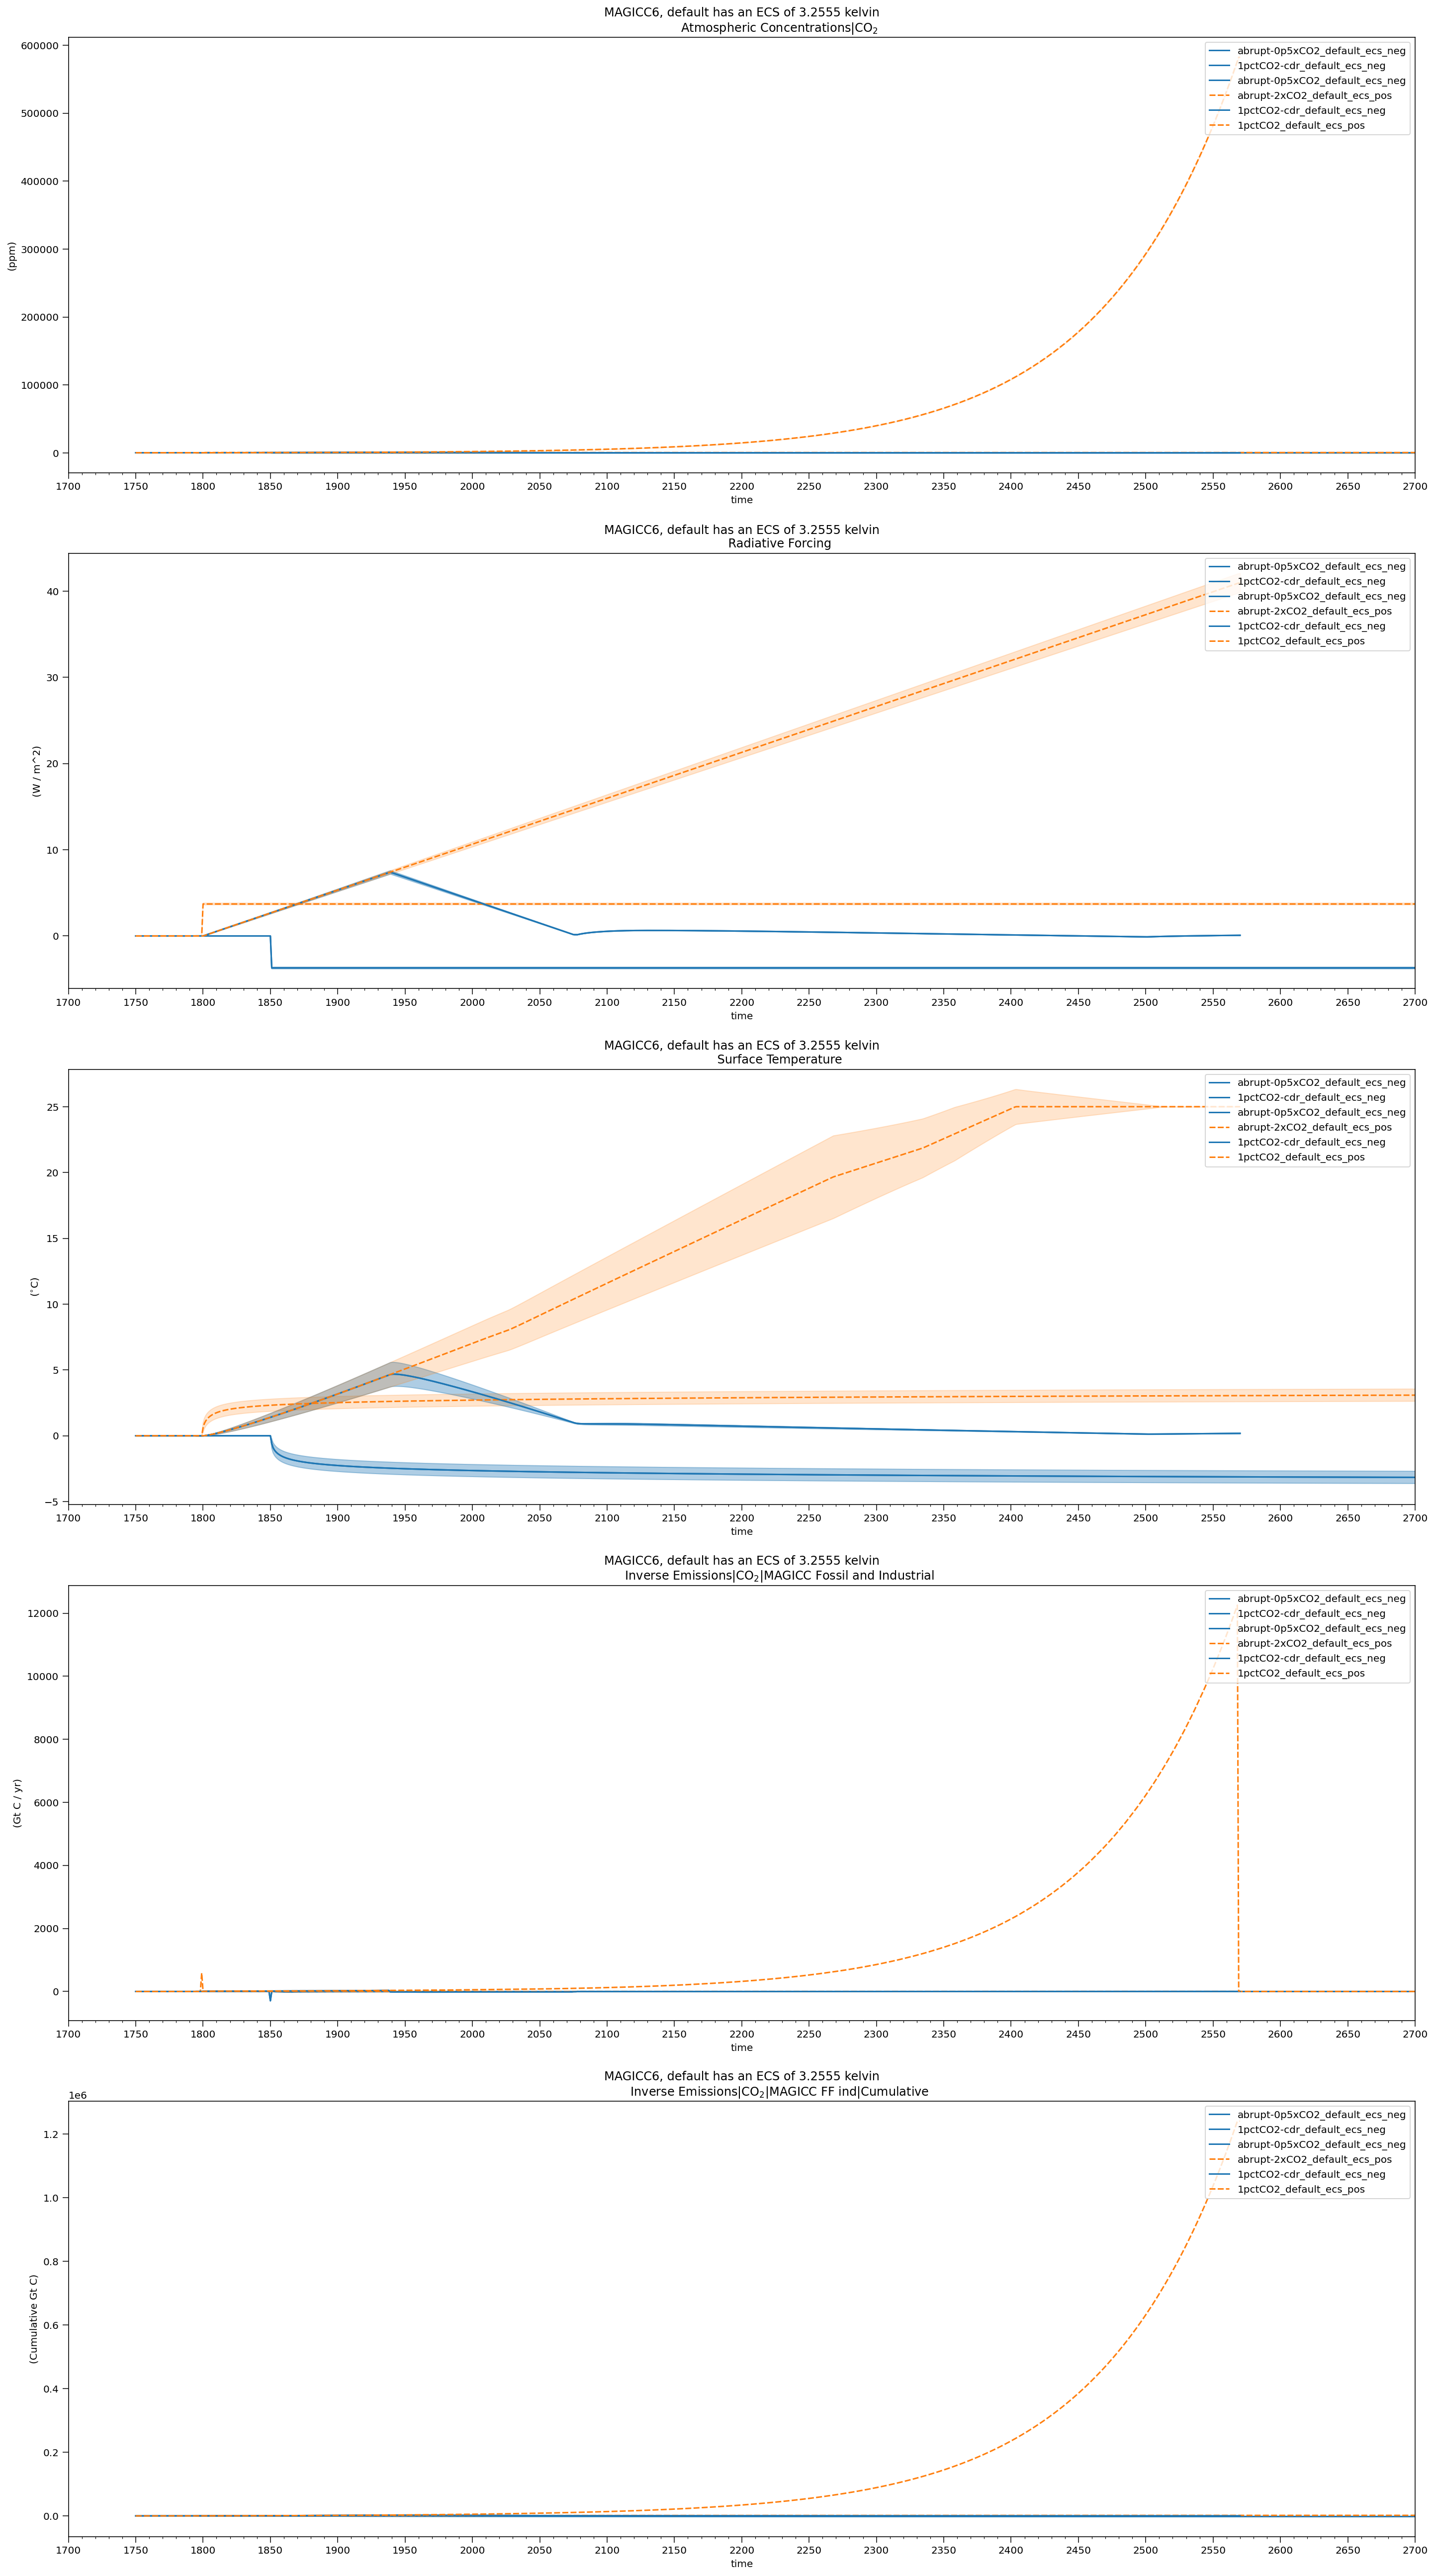

In [18]:
ecsdir = 'neg'
ecsval = 'default_ecs_'
varall = res.filter(scenario='1pctCO2-cdr_'+ecsval+ecsdir)['variable'].unique()
utils.graphstart = 1765
utils.graphend = 2700
fig, axes = plt.subplots((len(varall)), 1, figsize=(20, 36))
for n, onevar in enumerate(varall):
    for v in [ecsdir, 'pos']:
        for name in ['abrupt', '1pct']:
            ts = rcollection[ecsval+v]['timeseries'].filter(variable=onevar, scenario=name+'*default*')
            ts.lineplot(ax=axes[n], style='scenario')
            utils.ylabel = res.filter(variable=onevar)['unit'].iloc[[0]].all()
            utils.title = (f"MAGICC6, default has an ECS of {rcollection[ecsval+ecsdir]['ecs']:.4f}\n\
                    {onevar}")
            axes[n].legend(loc='upper right')
            utils.plthelpr(axes[n],plt,profile='full')